In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

In [2]:
#Como siempre chequeamos que este el GPU o el CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [3]:
# Cargamos los datos de FASHION-MNIST
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
class ShowImage(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image)
        return image,label

In [5]:
train_dataset=ShowImage(train_dataset)
test_dataset=ShowImage(test_dataset)
len(train_dataset), len(test_dataset)

(60000, 10000)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self,n=64,p=0.1):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, n),
            nn.Dropout(p),
            nn.ReLU(),
            #nn.Linear(n, n)
        )
          
        self.decoder = torch.nn.Sequential(
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(n,28*28)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
  
# Instantiating the model and hyperparameters
#model = Autoencoder()
#criterion = torch.nn.MSELoss()
#num_epochs = 100
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
model=Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=784, bias=True)
  )
)


In [68]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=32):  
    # Calculamos cosas utiles que necesitamos
    num_samples = len(dataloader.dataset) #numero de muestras de entrenamiento
    # Seteamos el modelo en modo entrenamiento. Esto sirve para activar, por ejemplo, dropout, etc. durante la fase de entrenamiento.
    model.train()
    # Pasamos el modelo a la GPU si está disponible.        
    model = model.to(device)    
    # Iteramos sobre lotes (batchs)
    for batch,(X,y) in enumerate(dataloader):
        # Pasamos los tensores a la GPU si está disponible.
        X = X.to(device)
        y = y.to(device)      
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso cada 100 batchs
        if batch % verbose_each*len(X) == 0:
            loss   = loss.item()
            sample = batch*len(X) # Número de batch * número de muestras en cada batch
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{sample:>5d}/{num_samples:>5d}]")            
# De manera similar, definimos la función de validación y testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = len(dataloader.dataset)
    num_batches  = len(dataloader)
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #num_samples += y.size(0)            
            #frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [69]:
# Definimos hiperparámetros de entrenamiento
learning_rate = 1e-3
batch_size = 1000
num_epochs = 50
num_k = 1 #72
n=512#256#128#64

# Creamos una funcion de perdida
loss_fn = nn.MSELoss()
# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.

#sizes=[64,128,256,512]
#for n in sizes:
for k in range(num_k):
    # Creamos el modelo y el optimzador
    model = Autoencoder(n)
    # Creamos los dataloaders ...
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    # ... en particular, usamos el dataset de prueba (test) como dataset de validación
    valid_dataloader = DataLoader(test_dataset,batch_size=batch_size)         
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
    # Entrenamos el modelo y calcualmos curvas.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataloader,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataloader,model,loss_fn)
        valid_loss,valid_accu = test_loop(valid_dataloader,model,loss_fn)
        print(f"n={n} k={k} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"n":n,
                        "k":k,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu,
                        "valid_loss":valid_loss,
                        "valid_accu":valid_accu}
                        ,ignore_index=True)
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

n=512 k=0 epoch=0 train_loss=0.012066690111532807 train_accu=0.0 valid_loss=0.012051020935177802 valid_accu=0.0
n=512 k=0 epoch=1 train_loss=0.009372064207370082 train_accu=0.0 valid_loss=0.009388633631169796 valid_accu=0.0
n=512 k=0 epoch=2 train_loss=0.007805964311895271 train_accu=0.0 valid_loss=0.007827107049524783 valid_accu=0.0
n=512 k=0 epoch=3 train_loss=0.00693258010627081 train_accu=0.0 valid_loss=0.006954075256362558 valid_accu=0.0
n=512 k=0 epoch=4 train_loss=0.00647340496070683 train_accu=0.0 valid_loss=0.006499249022454023 valid_accu=0.0
n=512 k=0 epoch=5 train_loss=0.005954760996003946 train_accu=0.0 valid_loss=0.005982245691120625 valid_accu=0.0
n=512 k=0 epoch=6 train_loss=0.005675801952990393 train_accu=0.0 valid_loss=0.005705739837139845 valid_accu=0.0
n=512 k=0 epoch=7 train_loss=0.0054854178102687005 train_accu=0.0 valid_loss=0.005517134862020612 valid_accu=0.0
n=512 k=0 epoch=8 train_loss=0.0052428181981667875 train_accu=0.0 valid_loss=0.0052762755658477545 valid_

In [114]:
# Elegimos una imagen y calculamos la correspondiente prediccion generada por el modelo.
sample_idx = torch.randint(len(test_dataset),size=(1,)).item()
imagen,label = test_dataset[sample_idx]
print(f"imagen.shape={imagen.shape}")
imagen_gpu = imagen.to(device)
pred_gpu = model(imagen_gpu)
pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)) # Pasamos la predección a la CPU y le damos el formato de una imagen de 28x28 píxeles.

imagen.shape=torch.Size([1, 28, 28])


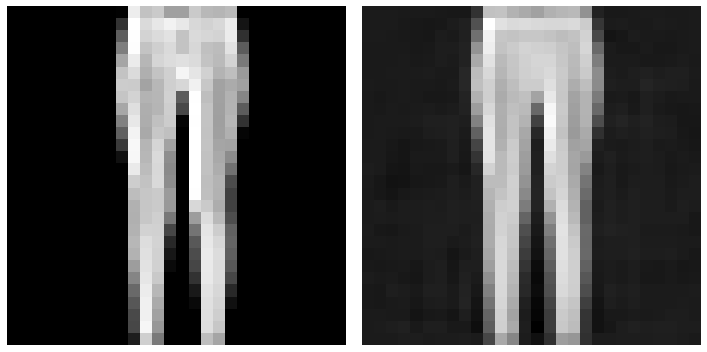

In [115]:
# Ploteamos una imagen y la correspondiente generada por el modelo.
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
ax = axes[0]
ax.axis("off")
ax.imshow(imagen.squeeze(),cmap="gray")
ax = axes[1]
ax.axis("off")
ax.imshow(pred_cpu.squeeze(),cmap="gray")
fig.tight_layout()
#plt.savefig("ggggggggs.jpg",bbox_inches='tight')
plt.savefig('bota_512neuronas5.jpg')
plt.show()

In [116]:
df1 = df.drop("k",1)
#df1

/tmp/ipykernel_149201/4142443721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1 = df.drop("k",1)


In [117]:
df2 = df1.pivot_table(index=["n","epoch"],aggfunc="count").reset_index()
#df2

In [118]:
df3 = df1.pivot_table(index=["n","epoch"],aggfunc="mean").reset_index()
#df3

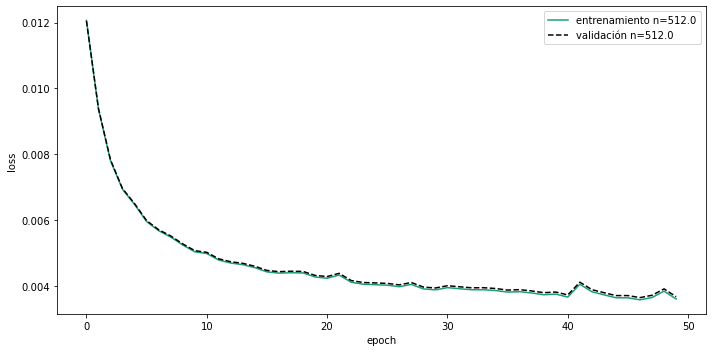

In [119]:
fig,axes=plt.subplots(1,1)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color,n in zip(colors,df["n"].unique()):
    dfn = df3[df3["n"]==n]
    x = dfn["epoch"]
    ax = axes
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"entrenamiento n={n}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"validación n={n}",color='black',linestyle='--')
    ax.legend()
    #ax = axes[1]
    #ax.set_xlabel("epoch")
    #ax.set_ylabel("accuracy")
    #ax.plot(x,dfn["train_accu"],label=f"train n={n}",color=color)
    #ax.plot(x,dfn["valid_accu"],label=f"test n={n}",color='black',linestyle='--')
    #ax.legend()
fig.tight_layout()
plt.savefig('loss_512.jpg')
plt.show()